<a href="https://colab.research.google.com/github/florian-frey/AudioSimilarity/blob/main/src/classifier/CNNGenreClassifierASS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Genre Classifier based on Spectrograms of the FMA Dataset

# 1 Setup

## 1.1 Imports

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import shutil
import math

import os
import re
# import argparse
import pandas as pd
import numpy as np
from PIL import Image
import librosa
import librosa.display
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## 1.2 Copy Data

In [ ]:
# connect to google drive --> allows to store kaggle.json API token under the main folder in the drive,
#   so that it doesn't have to be uploaded every time
# Alternatively the kaggle.json can be uploaded under /content/

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DATA_DIR = "/content/data/"
if not os.path.exists(DATA_DIR):
  shutil.copytree("/content/drive/MyDrive/SpectrogramsASS/", DATA_DIR)

## 1.5 Data Exploration

In [ ]:
# configuration
VAL_SIZE = 0.2
TEST_SIZE = 0.2
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 16
# NUM_CHANNELS has to be 3 for "rgb" and 1 for "grayscale"
NUM_CHANNELS = 3

In [ ]:
# load the training data set as rgb images
train_ds = tf.keras.utils.image_dataset_from_directory(
  DATA_DIR,
  validation_split=VAL_SIZE+TEST_SIZE,
  label_mode="categorical",
  subset="training",
  # color_mode="grayscale",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

# load validation data set
val_test_ds = tf.keras.utils.image_dataset_from_directory(
  DATA_DIR,
  validation_split=VAL_SIZE+TEST_SIZE,
  label_mode="categorical",
  subset="validation",
  # color_mode="grayscale",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

Found 7916 files belonging to 8 classes.
Using 4750 files for training.
Found 7916 files belonging to 8 classes.
Using 3166 files for validation.


In [ ]:
# store class names
CLASS_NAMES = train_ds.class_names
CLASS_NAMES

['Electronic',
 'Experimental',
 'Folk',
 'Hip-Hop',
 'Instrumental',
 'International',
 'Pop',
 'Rock']

In [ ]:
# split validation data set in val_ds and test_ds
val_batches = len(val_test_ds)
test_ds = val_test_ds.take(val_batches // 2)
val_ds = val_test_ds.skip(val_batches // 2)

# count number of batches in training, validation and test dataset
print(f"""The dataset is distributed in :
  - {len(train_ds)} Batches for training
  - {len(test_ds)} Batches for testing
  - {len(val_ds)} Batches for validation with each {BATCH_SIZE} images per Batch
      """)

The dataset is distributed in :
  - 297 Batches for training
  - 99 Batches for testing
  - 99 Batches for validation with each 16 images per Batch
      


In [ ]:
# count number of items in each class
def count_images_in_dataset(dataset, print_items: bool = False, dataset_description: str = "Training"):
    ds_class_counts = []
    for images, labels in dataset:
        class_counts = tf.reduce_sum(labels, axis=0)
        ds_class_counts.append(class_counts)
    ds_class_counts = tf.reduce_sum(ds_class_counts, axis=0)
    # Print the number of images in each class for the current dataset optional
    if print_items:
        for i, class_name in enumerate(CLASS_NAMES):
            print(f"{dataset_description} - Class '{class_name}': {int(ds_class_counts[i])}")
    return ds_class_counts

In [ ]:
# store occurences of each class in the train, test & val datasets in a dict
dataset_number_of_occurences = {}
for dataset, print_items, dataset_description in [[train_ds, False, "Training"], [test_ds, False, "Test"], \
 [val_ds, False, "Validation"]]:
     dataset_number_of_occurences[dataset_description] = count_images_in_dataset(dataset, print_items, dataset_description)

In [ ]:
# aggregate occurences over the different datasets, to see the class distribution over the whole dataset
all_classes_count = {}
for counter, key in enumerate(CLASS_NAMES):
  all_classes_count[key] = dataset_number_of_occurences['Training'][counter] + dataset_number_of_occurences['Test'][counter] + \
  dataset_number_of_occurences['Validation'][counter]

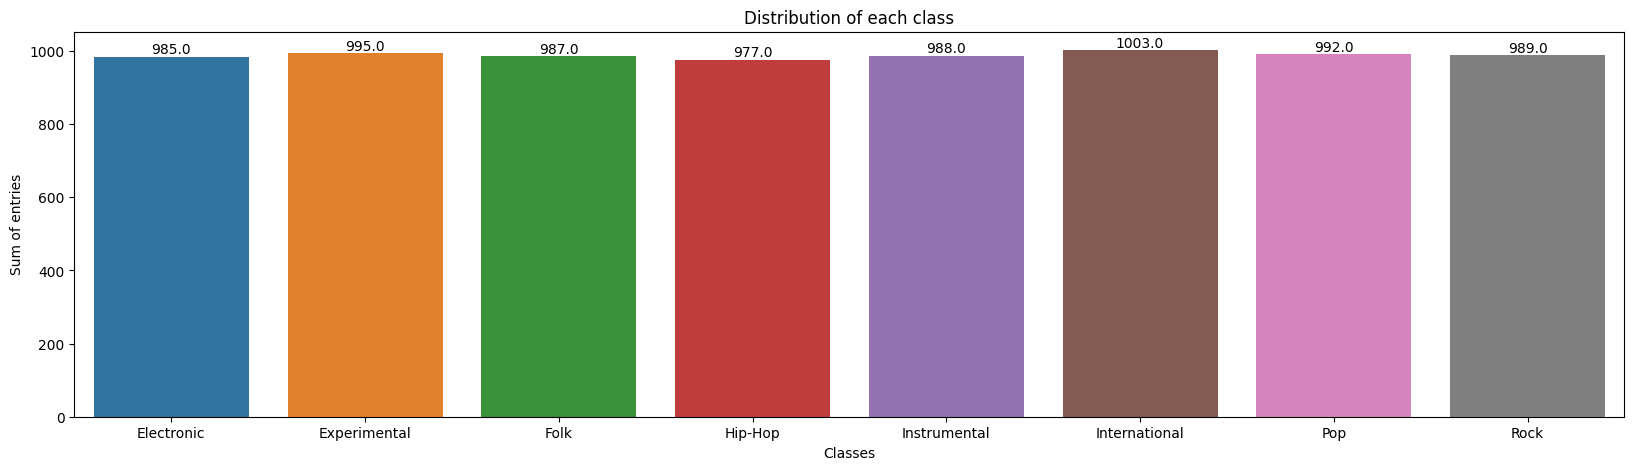

In [ ]:
# plot data frequency for the whole dataset
plt.figure(figsize=(20,5))
data = pd.DataFrame(data = {'class_name': all_classes_count.keys(), 'sum of entries': all_classes_count.values()})
data["sum of entries"] = data["sum of entries"].astype("int32")
ax = sns.barplot(data = data, x= "class_name", y="sum of entries")
ax.set(xlabel = "Classes", ylabel = "Sum of entries")
for p in ax.patches:
    ax.annotate(str(p.get_height()), xy=(p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')
plt.title(f"Distribution of each class")
plt.show()

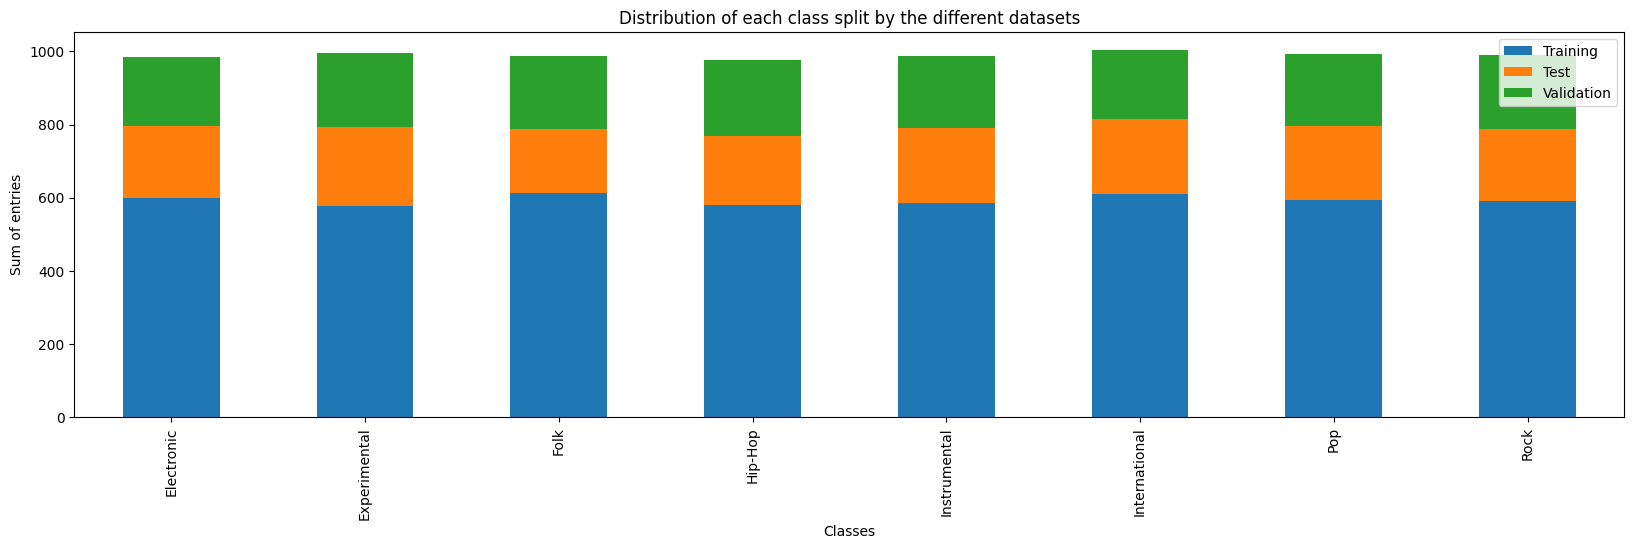

In [ ]:
# plot data frequency by set
df_counts_by_classes: pd.DataFrame = pd.DataFrame(dataset_number_of_occurences, index=CLASS_NAMES)
fig, axs = plt.subplots(figsize=(20,5))
axs.set_title(f"Distribution of each class split by the different datasets")
axs.set(xlabel = "Classes", ylabel = "Sum of entries")
df_counts_by_classes.plot(kind='bar', stacked=True, ax=axs)
fig.show()

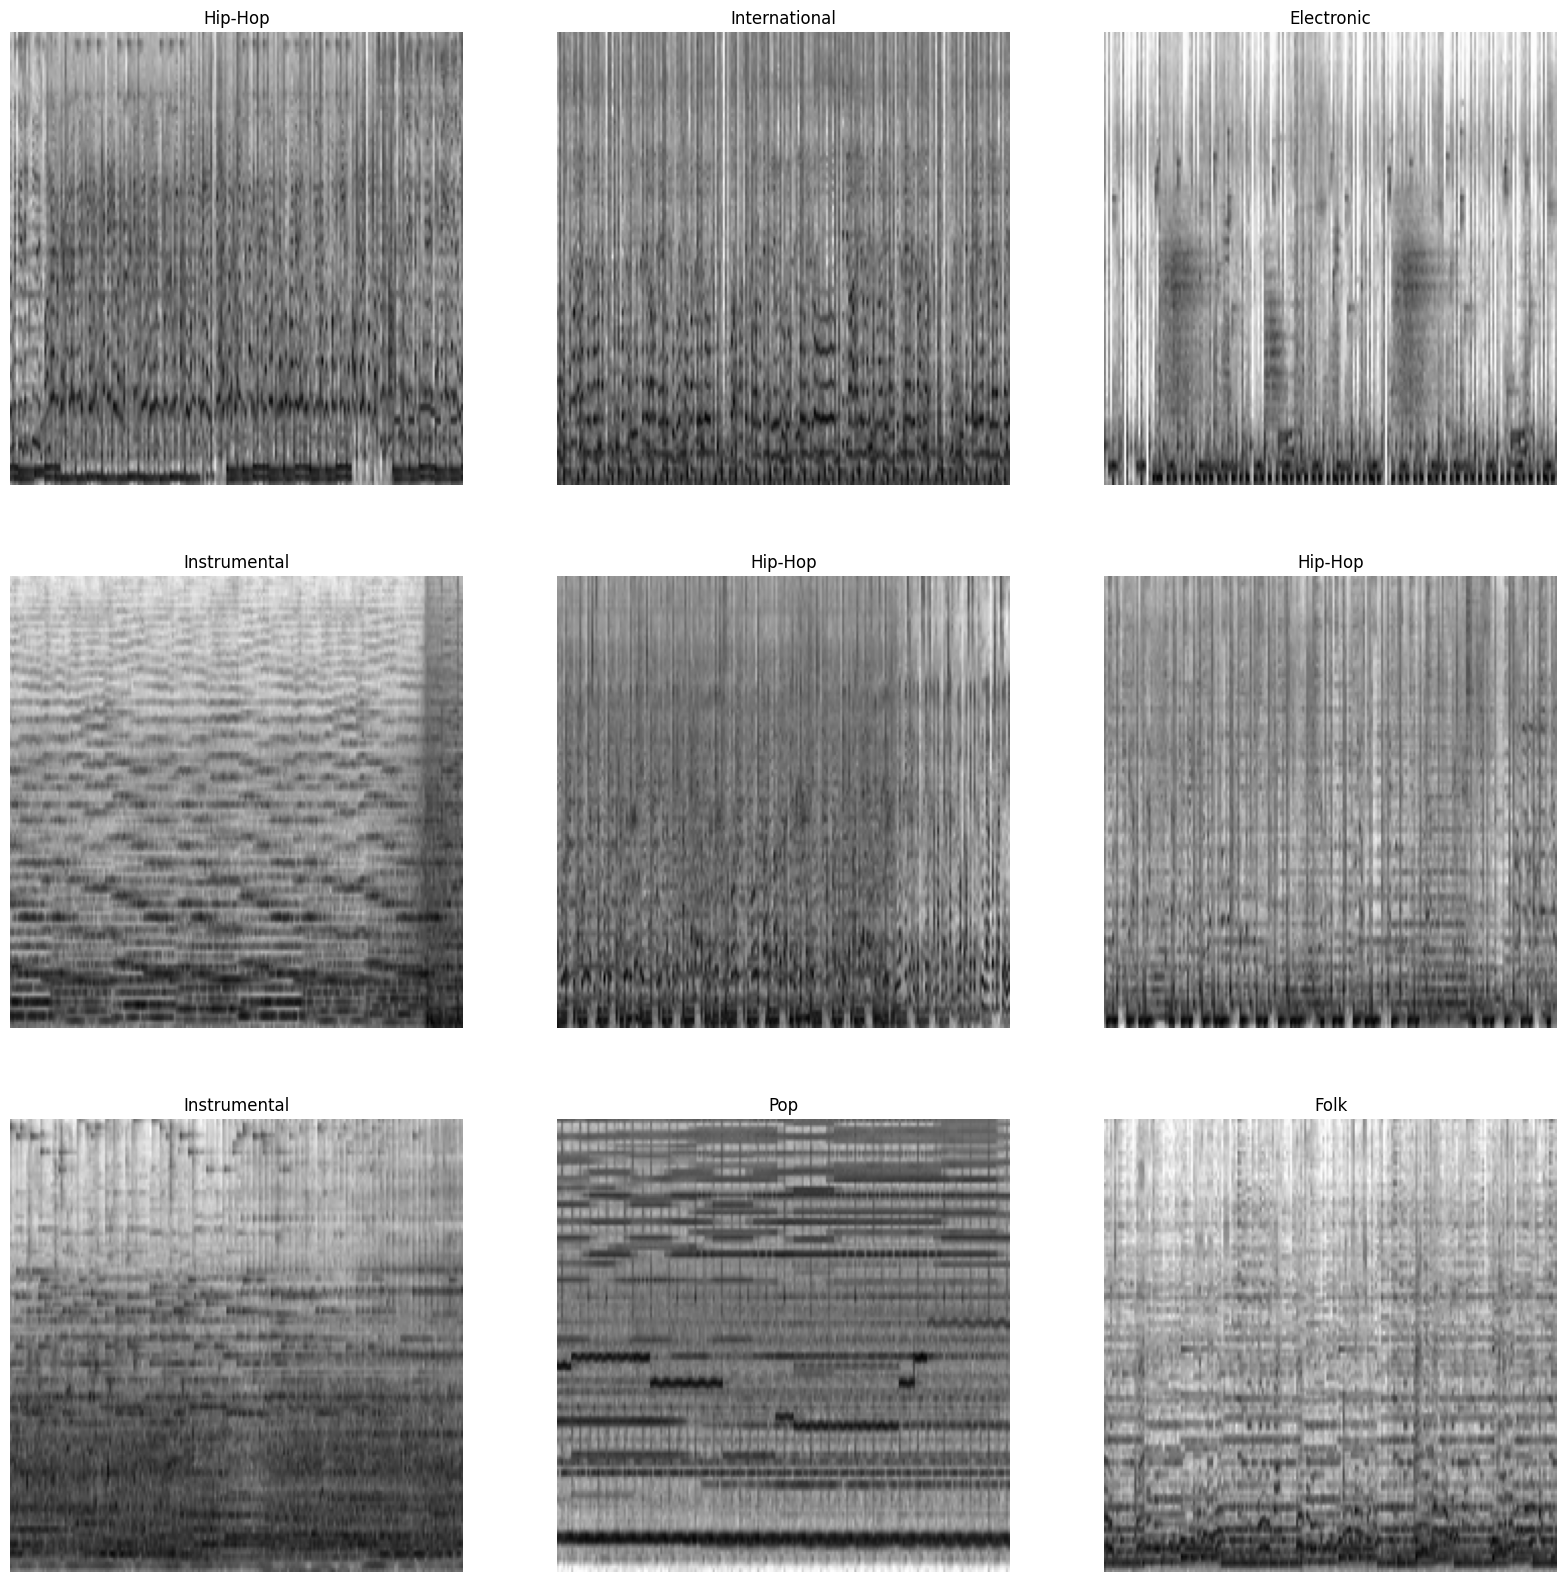

In [ ]:
# plot first 9 items of the training dataset
plt.figure(figsize=(20, 20))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"), cmap="gray")
        plt.title(CLASS_NAMES[tf.argmax(labels[i])])
        plt.axis("off")

# 2. Modeltraining

In [ ]:
# Training parameter
EPOCHS = 20
EARLY_STOPPING_PATIENCE = math.sqrt(EPOCHS)
num_classes = len(CLASS_NAMES)

# setup early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(patience=EARLY_STOPPING_PATIENCE,
                                                  verbose=1,
                                                  restore_best_weights=True)

In [ ]:
# define default input layer
def get_input_layer():
    input = tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS))
    input_layer = tf.keras.layers.Rescaling(1./255)(input)
    return input, input_layer

input, input_layer = get_input_layer()

In [ ]:
# function to create the vgg16 model from tensorflow optional with pre-trained weights
def create_vgg_16_base(weights: str, input_layer):
    base_model = tf.keras.applications.vgg16.VGG16(include_top=False,
                                      weights=weights,
                                      input_tensor=None,
                                      input_shape=(IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS),
                                      pooling=None)(input_layer)

    vgg16_model = tf.keras.layers.Flatten()(base_model)
    vgg16_model = tf.keras.layers.Dense(128, activation='relu')(vgg16_model)
    vgg16_model = tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')(vgg16_model)

    return vgg16_model

In [ ]:
# create a vgg 16 like model with data augmentation layer and pre-trained weights and display the summary
vgg_16_base_model_imagenet = create_vgg_16_base("imagenet", input_layer)
vgg_16_model_pre_trained = tf.keras.Model(inputs=input, outputs=vgg_16_base_model_imagenet)

# create optimizer with optimal learning rate --> weights already included --> smaller learning rate
optimizer_training_vgg_pre_trained = tf.keras.optimizers.Adam(learning_rate=1e-4)

vgg_16_model_pre_trained.compile(optimizer=optimizer_training_vgg_pre_trained,
                                 loss='categorical_crossentropy',
                                 metrics=['accuracy'])

vgg_16_model_pre_trained.summary()

58889256/58889256 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 dense_1 (Dense)             (None, 8)                 1032      
                                                              

In [ ]:
# Train the model with data augmentation and early stopping
history_vgg_16_lr = vgg_16_model_pre_trained.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1,
    batch_size=BATCH_SIZE,
    callbacks=early_stopping
)

Epoch 1/20
297/297 [==============================] - 99s 264ms/step - loss: 1.9311 - accuracy: 0.2543 - val_loss: 1.7362 - val_accuracy: 0.3470
Epoch 2/20
297/297 [==============================] - 73s 245ms/step - loss: 1.6803 - accuracy: 0.3891 - val_loss: 1.5927 - val_accuracy: 0.4090
Epoch 3/20
297/297 [==============================] - 73s 245ms/step - loss: 1.5681 - accuracy: 0.4284 - val_loss: 1.5679 - val_accuracy: 0.4387
Epoch 4/20
297/297 [==============================] - 73s 245ms/step - loss: 1.4871 - accuracy: 0.4558 - val_loss: 1.5093 - val_accuracy: 0.4583
Epoch 5/20
297/297 [==============================] - 74s 249ms/step - loss: 1.4026 - accuracy: 0.4878 - val_loss: 1.4604 - val_accuracy: 0.4867
Epoch 6/20
297/297 [==============================] - 73s 243ms/step - loss: 1.2985 - accuracy: 0.5257 - val_loss: 1.5200 - val_accuracy: 0.4659
Epoch 7/20
297/297 [==============================] - 73s 244ms/step - loss: 1.2135 - accuracy: 0.5674 - val_loss: 1.4353 - val_ac

In [ ]:
vgg_16_model_pre_trained.evaluate(test_ds)

99/99 [==============================] - 7s 66ms/step - loss: 1.4263 - accuracy: 0.5006


[1.4262946844100952, 0.5006313323974609]